# The overview of the basic approaches to solving the Uplift Modeling problem

<br>
<center>
    <a href="https://colab.research.google.com/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero_EN.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg">
    </a>
    <br>
    <b><a href="https://github.com/maks-sh/scikit-uplift/">SCIKIT-UPLIFT REPO</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/">SCIKIT-UPLIFT DOCS</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/user_guide/index.html">USER GUIDE</a></b>
    <br>
    <b><a href="https://nbviewer.jupyter.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero.ipynb">RUSSIAN VERSION</a></b>
</center>

## Content

* [Introduction](#Introduction)
* [1. Single model approaches](#1.-Single-model-approaches)
    * [1.1 Single model](#1.1-Single-model-with-treatment-as-feature)
    * [1.2 Class Transformation](#1.2-Class-Transformation)
* [2. Approaches with two models](#2.-Approaches-with-two-models)
    * [2.1 Two independent models](#2.1-Two-independent-models)
    * [2.2 Two dependent models](#2.2-Two-dependent-models)
* [Conclusion](#Conclusion)

## Introduction

Before proceeding to the discussion of uplift modeling, let's imagine some situation:

A customer comes to you with a certain problem: it is necessary to advertise a popular product using the sms.
You know that the product is quite popular, and it is often installed by the customers without communication, that the usual binary classification will find the same customers, and the cost of communication is critical for us...

And then you begin to understand that the product is already popular, that the product is often installed by customers  without communication, that the usual binary classification will find many such customers, and the cost of communication is critical for us...

Historically, according to the impact of communication, marketers divide all customers into 4 categories:

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/client_types.png" alt="Customer types"/>
</p>

- **`Do-Not-Disturbs`** *(a.k.a. Sleeping-dogs)* have a strong negative response to a marketing communication. They are going to purchase if *NOT* treated and will *NOT* purchase *IF* treated. It is not only a wasted marketing budget but also a negative impact. For instance, customers targeted could result in rejecting current products or services. In terms of math: $W_i = 1, Y_i = 0$ or $W_i = 0, Y_i = 1$.
- **`Lost Causes`** will *NOT* purchase the product *NO MATTER* they are contacted or not. The marketing budget in this case is also wasted because it has no effect. In terms of math: $W_i = 1, Y_i = 0$ or $W_i = 0, Y_i = 0$.
- **`Sure Things`** will purchase *ANYWAY* no matter they are contacted or not. There is no motivation to spend the budget because it also has no effect. In terms of math: $W_i = 1, Y_i = 1$ or $W_i = 0, Y_i = 1$.
- **`Persuadables`** will always respond *POSITIVE* to the marketing communication. They is going to purchase *ONLY* if contacted (or sometimes they purchase *MORE* or *EARLIER* only if contacted). This customer's type should be the only target for the marketing campaign. In terms of math: $W_i = 0, Y_i = 0$ or $W_i = 1, Y_i = 1$.


Because we can't communicate and not communicate with the customer at the same time, we will never be able to observe exactly which type a particular customer belongs to.

Depends on the product characteristics and the customer base structure some types may be absent. In addition, a customer response depends heavily on various characteristics of the campaign, such as a communication channel or a type and a size of the marketing offer. To maximize profit, these parameters should be selected.

Thus, when predicting uplift score and selecting a segment by the highest score, we are trying to find the only one type: **persuadables**.

Thus, in this task, we don’t want to predict the probability of performing a target action, but to focus the advertising budget on the customers who will perform the target action only when we interact. In other words, we want to evaluate two conditional probabilities separately for each client:


* Performing a targeted action when we influence the client. 
    We will refer such clients to the **test group (aka treatment)**: $P^T = P(Y=1 | W = 1)$,
* Performing a targeted action without affecting the client. 
    We will refer such clients to the **control group (aka control)**: $P^C = P(Y=1 | W = 0)$,

where $Y$ is the binary flag for executing the target action, and $W$ is the binary flag for communication (in English literature, _treatment_)

The very same cause-and-effect effect is called **uplift** and is estimated as the difference between these two probabilities:

$$ uplift = P^T - P^C = P(Y = 1 | W = 1) - P(Y = 1 | W = 0) $$

Predicting uplift is a cause-and-effect inference task. The point is that you need to evaluate the difference between two events that are mutually exclusive for a particular client (either we interact with a person, or not; you can't perform two of these actions at the same time). This is why additional requirements for source data are required for building uplift models.

To get a training sample for the uplift simulation, you need to conduct an experiment: 
1. Randomly split a representative part of the client base into a test and control group
2. Communicate with the test group

The data obtained as part of the design of such a pilot will allow us to build an uplift forecasting model in the future. It is also worth noting that the experiment should be as similar as possible to the campaign, which will be launched later on a larger scale. The only difference between the experiment and the campaign should be the fact that during the pilot, we choose random clients for interaction, and during the campaign - based on the predicted value of the Uplift. If the campaign that is eventually launched differs significantly from the experiment that is used to collect data about the performance of targeted actions by clients, then the model that is built may be less reliable and accurate.

So, the approaches to predicting uplift are aimed at assessing the net effect of marketing campaigns on customers.

All classical approaches to uplift modeling can be divided into two classes:
1. Approaches with the same model
2. Approaches using two models

Let's download [RetailHero.ai contest data](https://retailhero.ai/c/uplift_modeling/overview):

In [1]:
import urllib.request

url = 'https://drive.google.com/u/0/uc?id=1fkxNmihuS15kk0PP0QcphL_Z3_z8LLeb&export=download'
urllib.request.urlretrieve(url, '/content/retail_hero.zip')

!unzip /content/retail_hero.zip
!pip install scikit-uplift catboost==0.22 -U

Now let's preprocess it a bit:

In [2]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# reading data
df_clients = pd.read_csv('/content/uplift_data/clients.csv', index_col='client_id')
df_train = pd.read_csv('/content/uplift_data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('/content/uplift_data/uplift_test.csv', index_col='client_id')

# extracting features
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

For convenience, we will declare some variables:

In [3]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1. Single model approaches

### 1.1 Single model with treatment as feature

The most intuitive and simple uplift modeling technique. A training set consists of two groups: treatment samples and control samples. There is also a binary treatment flag added as a feature to the training set. After the model is trained, at the scoring time it is going to be applied twice:
with the treatment flag equals `1` and with the treatment flag equals `0`. Subtracting these model's outcomes for each test sample, we will get an estimate of the uplift.

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel.png" alt="Solo model with treatment as a feature"/>
</p>

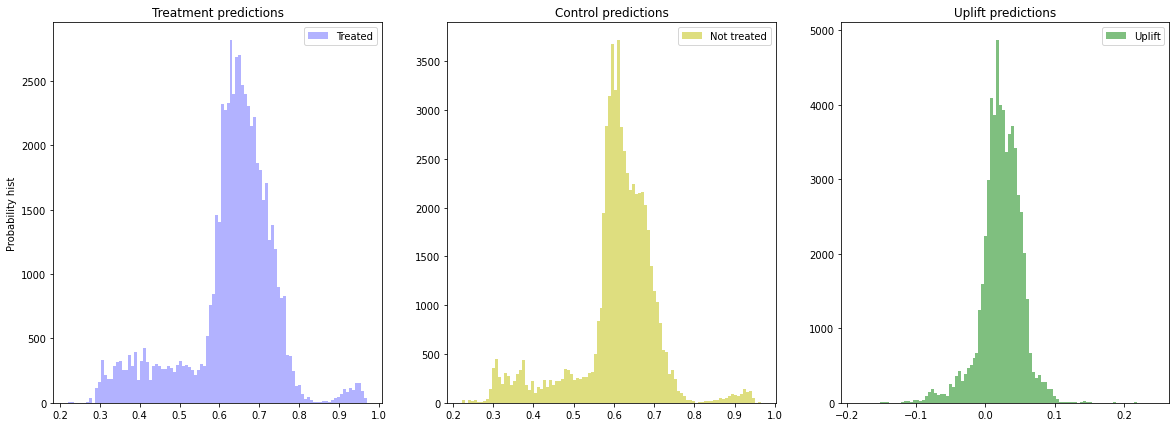

In [4]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [5]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,65.214393
1,issue_redeem_delay,12.564364
2,age,7.891613
3,first_issue_time,7.262806
4,treatment,4.362077
5,gender,2.704747


### 1.2 Class Transformation

Simple yet powerful and mathematically proven uplift modeling method, presented in 2012.
The main idea is to predict a slightly changed target $Z_i$:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$

where 

* $Z_i$ - new target variable of the $i$ client; 
* $Y_i$ - target variable of the $i$ client;
* $W_i$ - flag for communication of the $i$ client;  


In other words, the new target equals 1 if a response in the treatment group is as good as a response in the control group and equals 0 otherwise:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Let's go deeper and estimate the conditional probability of the target variable:

$$ 
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

We assume that $ W $ is independent of $X = x$ by design.
Thus we have: $P(W | X = x) = P(W)$ and

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Also, we assume that $P(W = 1) = P(W = 0) = \frac{1}{2}$, which means that during the experiment the control and the treatment groups were divided in equal proportions. Then we get the following:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Thus, by doubling the estimate of the new target $Z$ and subtracting one we will get an estimation of the uplift:

$$
uplift = 2 \cdot P(Z=1) - 1
$$

This approach is based on the assumption: $P(W = 1) = P(W = 0) = \frac{1}{2}$,  That is the reason that it has to be used only in cases where the number of treated customers (communication) is equal to the number of control customers (no communication).

In [6]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/Users/Maksim/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

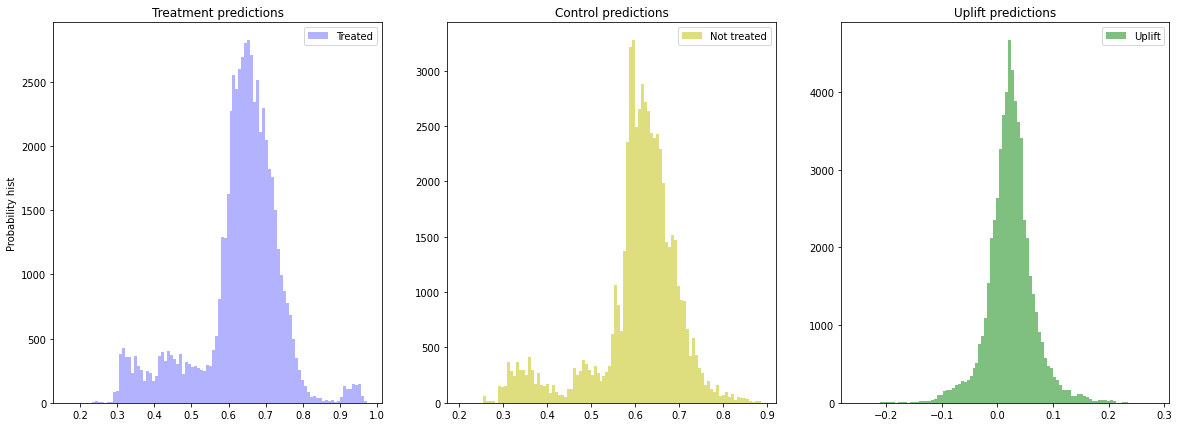

In [7]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Two dependent models

The dependent data representation approach is based on the classifier chain method originally developed
for multi-class classification problems. The idea is that if there are $L$ different classifiers, each of which solves the problem of binary classification and in the learning process,
each subsequent classifier uses the predictions of the previous ones as additional features.
The authors of this method proposed to use the same idea to solve the problem of uplift modeling in two stages.

At the beginning we train the classifier based on the control data:

$$
P^C = P(Y=1| X, W = 0),
$$

Next, we estimate the $P_C$ predictions and use them as a feature for the second classifier.
It effectively reflects a dependency between treatment and control datasets:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

To get the uplift for each observation, calculate the difference:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Intuitively, the second classifier learns the difference between the expected probability in the treatment and the control sets which is the uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control.png", alt="Two dependent models"/>
</p>

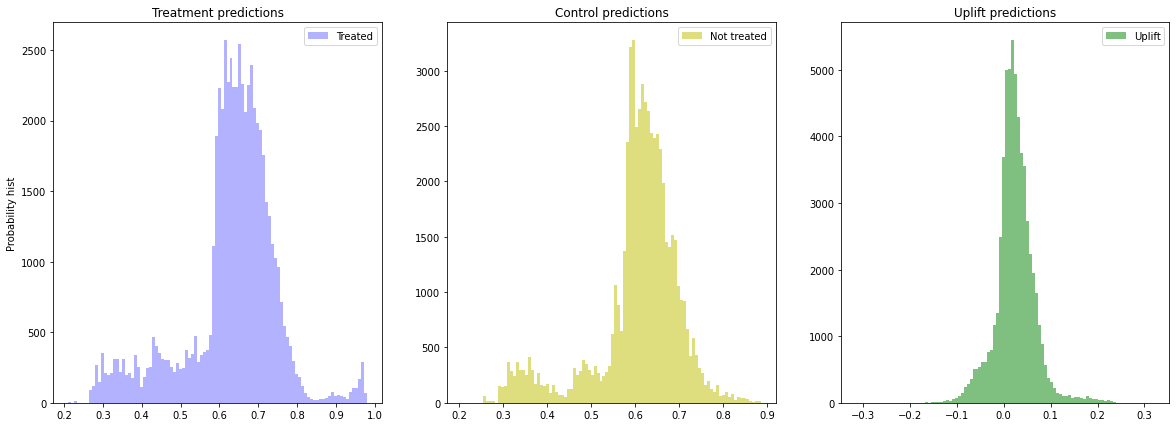

In [8]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Similarly, you can first train the $P^T$ classifier, and then use its predictions as a feature for the $P^C$ classifier.

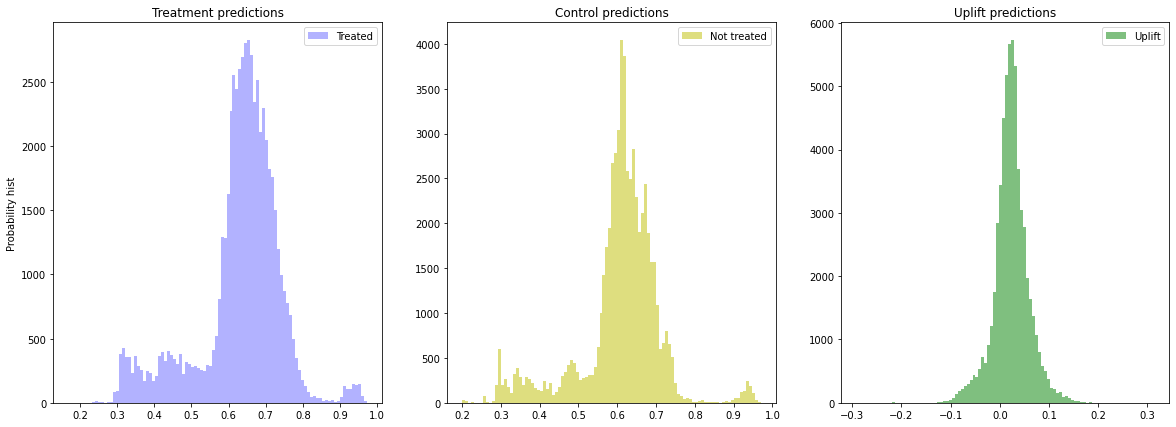

In [9]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Conclusion

Let's consider which method performed best in this task and use it to speed up the test sample:

In [10]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.061775
2,TwoModels,0.051637
3,TwoModels_ddr_control,0.047793
0,SoloModel,0.041614
4,TwoModels_ddr_treatment,0.033752


From the table above you can see that the current task suits best for the approach to the transformation of the target line. Let's train the model on the entire sample and predict the test.

In [11]:
ct_full = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct_full = ct_full.fit(
    X_train_full, 
    y_train_full, 
    treat_train_full, 
    estimator_fit_params={'cat_features': cat_features}
)

X_test.loc[:, 'uplift'] = ct_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv('sub1.csv')

!head -n 5 sub1.csv

/Users/Maksim/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


client_id,uplift
000048b7a6,0.03777380619745441
000073194a,0.0402001184660159
00007c7133,-0.001255842638942739
00007f9014,0.03165865533189738


In [12]:
ct_full = pd.DataFrame({
    'feature_name': ct_full.estimator.feature_names_,
    'feature_score': ct_full.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_full

,feature_name,feature_score
0,first_redeem_time,79.642055
1,age,8.808502
2,issue_redeem_delay,5.113192
3,first_issue_time,3.558522
4,gender,2.877728


This way we got acquainted with uplift modeling and considered the main basic approaches to its construction. What's next? Then you can plunge them into the intelligence analysis of data, generate some new features, select the models and their hyperparameters and learn new approaches and libraries.

**Thank you for reading to the end.**

**I will be pleased if you support the project with an star on [github](https://github.com/maks-sh/scikit-uplift/) or tell your friends about it.**